In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

In [3]:
from scipy.special import softmax
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
import xgboost as xgb
from scipy.optimize import LinearConstraint, Bounds, minimize
import warnings
warnings.filterwarnings("ignore", message="delta_grad == 0.0. Check if the approximated function is linear.")

class SchoolManifold():

    def __init__(self, embeddings_df: pd.DataFrame, k = 15, ):
        self.embeddings_df = embeddings_df
        self.embeddings = self.embeddings_df.drop(labels = ["unitid"], axis =1)

        self.k = k

    
    def _compute_neighbors(self, k: int):
        knn = NearestNeighbors(n_neighbors = k, algorithm="auto")
        knn.fit(self.embeddings.values)
        dists, indices = knn.kneighbors(self.embeddings.values)
        self.neighbor_dists = dists
        self.neighbor_indices = indices


    def preprocess_for_target(self, target_df: pd.DataFrame, target_col_ind: int = None, target_col_lab = None, total_column_lab = None):
        if (target_col_ind is not None):
            target_col_lab = target_df.columns[target_col_ind]

        if (target_col_lab is None):
            raise ValueError("Either target_col_ind or target_col_lab must not be None")

        self.total_column_lab = total_column_lab
        merged = pd.merge(self.embeddings_df, target_df, how= "inner", on = "unitid")
        
        self.embeddings = merged[self.embeddings.columns]
        self._compute_neighbors(self.k)

        self.target_df = merged[target_df.columns]
        self.features = self.target_df.drop(labels = ["unitid", target_col_lab], axis = 1)
        orig_columns = self.features.columns
        self.target = self.target_df[target_col_lab]
        self.schools = self.target_df["unitid"]

        inds_of_target_in_original = merged.index.values
        neighbor_inds_of_target_in_original = self.neighbor_indices[inds_of_target_in_original]
        neighbor_dists_of_target_col = self.neighbor_dists[inds_of_target_in_original]

        vals_of_target_col = merged[target_col_lab].values
        neighbor_vals_of_target_col =  vals_of_target_col[neighbor_inds_of_target_in_original]
        
        features_of_target_col = merged[orig_columns].values
        neighbor_features_of_target_col = features_of_target_col[neighbor_inds_of_target_in_original]

        mask = neighbor_vals_of_target_col > 1.1 * vals_of_target_col.reshape(-1, 1)
        neighbor_weights_of_target_col = np.where(mask, neighbor_dists_of_target_col, np.PINF)
        neighbor_weights_of_target_col = softmax(-neighbor_weights_of_target_col, axis = 1)

        self.mask = mask
        self.v_star = (neighbor_vals_of_target_col * neighbor_weights_of_target_col).sum(axis = 1)
        self.weights =  neighbor_weights_of_target_col
        self.neighbor_features = neighbor_features_of_target_col
        self.neighbor_target = neighbor_vals_of_target_col
        
        if (total_column_lab is not None):
            self.total_column = self.features[total_column_lab].values.reshape(-1,1)
            self.total_column_index = list(self.features.columns).index(total_column_lab)
            self.neighbor_features[:, :, self.total_column_index] = self.total_column
        
        self.vstars = np.where(np.isnan(self.v_star), self.target.values, self.v_star)
    

    def compute_deltas(self, reg, mode = "projection", eps = 0.1):
        self.reg = reg
        self.adjusted_features = np.sum(self.neighbor_features * self.weights[:, :, None], axis = 1)
        self.adjusted_features = np.where(np.isnan(self.adjusted_features), self.features.values, self.adjusted_features)

        if mode == "projection":
            # maintaining total spending constraint
            if (self.total_column_lab):
                # all_but_total_column = [x for x in range(self.features.shape[-1]) if x != self.total_column_index]
                # non_total_adjusted_features = self.adjusted_features[:, all_but_total_column]
                # non_total_features = self.features.values[:, all_but_total_column]
                # non_total_adjusted_features = non_total_adjusted_features / np.sum(non_total_adjusted_features, axis = 1).reshape(-1, 1)
                # non_total_adjusted_features = non_total_adjusted_features * np.sum(non_total_features, axis = 1).reshape(-1, 1)
                # self.adjusted_features[:, all_but_total_column] =  non_total_adjusted_features
                
                self.adjusted_features_df = pd.DataFrame(self.adjusted_features, columns = self.features.columns)
                self.deltas = self.adjusted_features - self.features.values
            
            if type(reg) == xgb.core.Booster:
                self.vhats = reg.predict(xgb.DMatrix(self.adjusted_features_df))
        
        if mode == "optimize":
            def objective_xgb(x, reg, df_cols):
                x_df = pd.DataFrame(x.reshape(1, -1), columns=list(df_cols))
                x = xgb.DMatrix(x_df)
                v = reg.predict(x)
                return -v
            
            def objective(x, reg, df_cols):
                v = reg.predict(pd.DataFrame(x.reshape(1,-1), columns=list(df_cols)))
                return -v
            d = self.adjusted_features.shape[-1]
            positive_constraint_A = np.eye(d)
            positive_constraint = LinearConstraint(positive_constraint_A, lb = 0, ub = np.inf)
            
            distance_constraint_A = np.eye(d)
            self.vhats = []
            for school, x0 in enumerate(self.features.values):
                if (np.allclose(x0, self.adjusted_features[school])):
                    self.vhats.append(self.target[school])
                    continue
                constraints = []

                vstar = self.vstars[school]

                if (self.total_column_lab is not None):
                    ub = np.zeros(d)
                    lb = 0.3 * x0.flatten()
                    ub[self.total_column_index] = x0[self.total_column_index]
                    other_cols = [x for x in range(d) if x != self.total_column_index]
                    ub[other_cols] = x0[other_cols] + eps * x0[other_cols]
                    
                    bounds = Bounds(lb = lb, ub = ub, keep_feasible=True)
                else:
                    bounds = Bounds(lb = np.zeros(d), ub = x0.flatten() + eps*x0.flatten(), keep_feasible=True)
                
                if type(reg) == xgb.core.Booster:
                    res = minimize(objective_xgb, x0= x0.flatten(), args = (reg, self.features.columns), method="Powell", bounds = bounds)
                else:
                    res = minimize(objective, x0= x0.flatten(), args = (reg, self.features.columns), method="Powell", bounds = bounds)

                self.vhats.append(-res.fun)
                self.adjusted_features[school] = res.x
                print(f"vhat: {-res.fun}, vstar: {vstar}, orig: {self.target[school]}")
                
                
        outcome_results = np.zeros((len(self.vhats), 3))
        outcome_results[:, 0] = self.target[:len(self.vhats)]
        outcome_results[:, 1] = self.vhats[:len(self.vhats)]
        outcome_results[:, 2] = self.vstars[:len(self.vhats)]
        
        outcome_results_df = pd.DataFrame(outcome_results, columns = ["original", "vhat", "vstar"])
        self.adjusted_features_df = pd.DataFrame(self.adjusted_features, columns = self.features.columns)

        self.results = pd.concat((outcome_results_df, self.adjusted_features_df), axis = 1)
        self.deltas = self.adjusted_features - self.features.values

        return self.results

        

### Academic Scores

In [5]:
ic_mca = pd.read_csv("../datasets/Clusters/IC_CLUSTERS_AND_MCA.csv")
ic_mca = ic_mca.loc[:, ic_mca.columns != "ic_cluster"]

academic_scores_act = pd.read_csv("../datasets/Target Features/score_prediction.csv", index_col=0)
academic_scores_act.drop(labels=["actcm75_scaled", "satcm75_scaled", "log_sat75_per_dollar_scaled", "log_sat75_per_dollar", "log_act75_per_dollar", "satcm75", "actcm75"], axis = 1, inplace=True)

In [6]:
manifold = SchoolManifold(ic_mca)

In [7]:
manifold.preprocess_for_target(academic_scores_act, target_col_lab="log_act75_per_dollar_scaled", total_column_lab="Total expenses")

/home/acowlagi/.conda/envs/datathon/lib/python3.9/site-packages/scipy/special/_logsumexp.py:214: RuntimeWarning: invalid value encountered in subtract
  return np.exp(x - logsumexp(x, axis=axis, keepdims=True))


In [9]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import pickle

xgb_reg = xgb.Booster()
xgb_reg.load_model("../models/log_act75_per_dollar_scaled_model.json")
xgb_reg.save_model("../models/log_act75_per_dollar_scaled_model.json")

In [10]:
results = manifold.compute_deltas(xgb_reg, mode = "optimize")

vhat: 0.9910404086112976, vstar: 0.5726446993110135, orig: 0.379413994518644
vhat: 1.4208067655563354, vstar: 0.4125721481358695, orig: 0.0174127467064182
vhat: 1.5554245710372925, vstar: 2.2914104032190394, orig: 0.95829270106815
vhat: 1.4892668724060059, vstar: 0.9249317592710484, orig: 0.7942337692931244
vhat: -0.4298776388168335, vstar: -0.09463513189379835, orig: -2.2492695405838523
vhat: 1.0219806432724, vstar: 0.7868135487640412, orig: 0.1338931574095301
vhat: 0.9910404086112976, vstar: 0.6433147736136492, orig: 0.4977059753331032
vhat: 0.9662987589836121, vstar: 0.8178314145613943, orig: -0.1315432269451632
vhat: 1.0647395849227905, vstar: 0.24688276547128374, orig: 0.0666422797736436
vhat: 0.9529484510421753, vstar: 0.5802136645042721, orig: 0.3285035080295177
vhat: 0.7333957552909851, vstar: 0.8278636831518748, orig: -0.4547742083836029
vhat: 1.5337491035461426, vstar: 0.7009240333279712, orig: 0.3638892983960661
vhat: 0.7444834113121033, vstar: -0.07741608972844571, orig: -0

In [11]:
results.to_csv("../results/student_caliber_act_results.csv", index = False)

### Plots

In [13]:
import seaborn as sns
sns.set_style('whitegrid')

In [12]:
results = pd.read_csv("../results/student_caliber_act_results.csv")

(-3.0, 4.0)

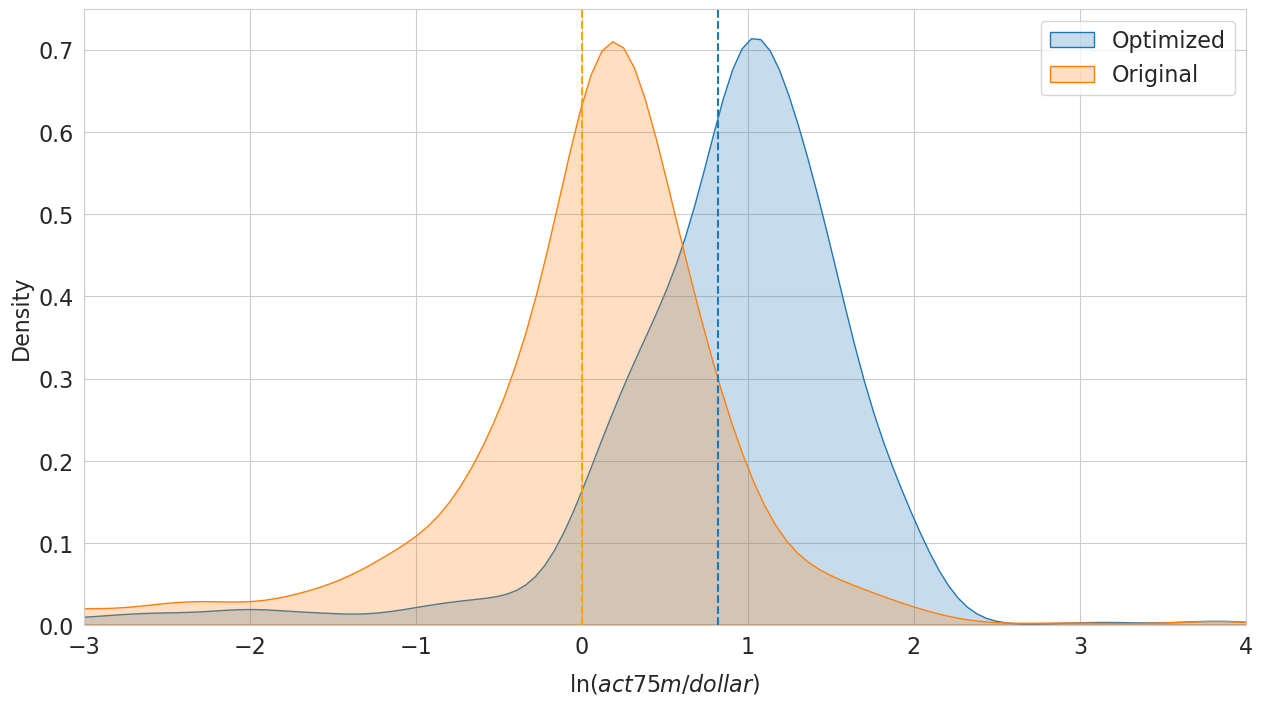

In [15]:
plt.figure(figsize=(15,8))
sns.kdeplot(results["vhat"], fill = True, label = "Optimized")
sns.kdeplot(results["original"],  fill = True, label = "Original")
plt.tick_params(labelsize=16)
plt.xlabel(r'$\ln (act75m / dollar)$', fontsize = 16, labelpad= 10)
plt.axvline(x = results["vhat"].mean(), linestyle = "--", color = 'C0')
plt.axvline(x = results["original"].mean(), linestyle = "--", color = "orange")
plt.legend(fontsize= 16)
plt.ylabel("Density", fontsize = 16)
plt.savefig("figs/Academic Caliber Optimum vs Original", bbox_inches = "tight")
plt.xlim((-3, 4))

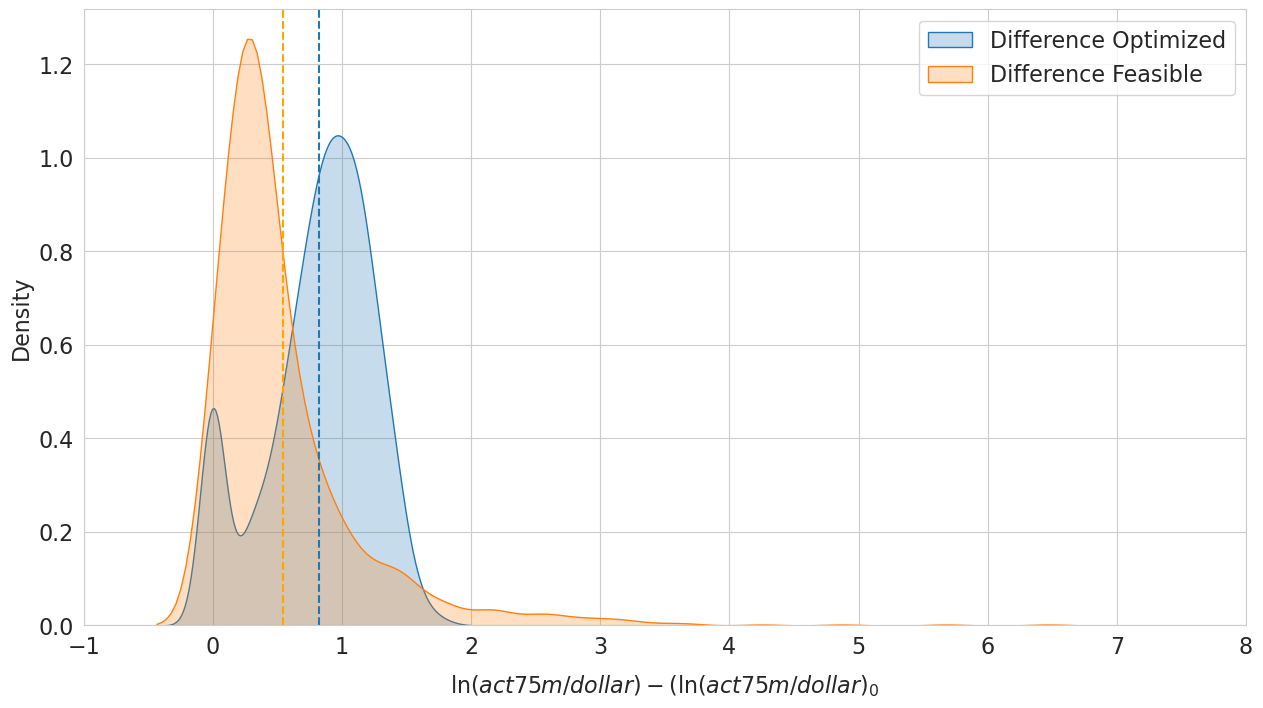

In [16]:
plt.figure(figsize=(15,8))
sns.kdeplot(results["vhat"] - results["original"], fill = True, label = "Difference Optimized")
sns.kdeplot(results["vstar"] - results["original"], fill = True, label = "Difference Feasible")
plt.axvline(x = (results["vhat"] - results["original"]).mean(), linestyle = "--", color = "C0")
plt.axvline(x = (results["vstar"] - results["original"]).mean(), linestyle = "--", color = "orange")
plt.tick_params(labelsize=16)
plt.xlabel(r'$\ln (act75m / dollar) - (\ln (act75m / dollar)_0$', fontsize = 16, labelpad= 10)
plt.legend(fontsize= 16)
plt.ylabel("Density", fontsize = 16)
plt.xlim((-1, 8))
plt.savefig("figs/Academic Caliber Optimum Feasible Difference", bbox_inches = "tight")

In [17]:
from scipy.stats import ttest_rel
rmse_xregr = 0.134
sensitivity_thresholds = [0, rmse_xregr, *rmse_xregr]

for sensitivity_threshold in sensitivity_thresholds:
    stat, pval = ttest_rel(results["vstar"] - sensitivity_threshold, results["original"], alternative = "greater")
    print(pval)

1.0048145193166695e-170
1.0167192146596496e-106
2.7090946769287544e-51


In [24]:
(results["vhat"] - results["original"]).shape

(1336,)

In [23]:
0.821 - 2* 0.134

0.5529999999999999